<a href="https://colab.research.google.com/github/VJsai45/Image-Caption-Generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining Models



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
import re
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
from IPython.display import clear_output

In [ ]:
seed = 23
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip

In [ ]:
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
! pip install -q kaggle
from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip -qq flickr-image-dataset.zip

 35% 2.82G/8.16G [02:07<03:52, 24.6MB/s]

In [ ]:
EMBED_DIM = 1024

EPOCHS = 30

BATCH_SIZE = 64

FF_DIM = 1024

IMG_SIZE = (299,299)

IMAGES_PATH = "Flicker8k_Dataset"

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# # Read text file using read csv and seperate on 'jpg'
# data = pd.read_csv('/content/Flickr8k.token.txt',sep="jpg",names=['image_name','caption'])
# data.head()

In [ ]:
data = pd.read_csv('/content/flickr30k_images/results.csv', sep='|')
data.head()

In [ ]:
data.rename(columns = {' comment':'caption'}, inplace = True)

In [ ]:
data = data.drop(data.columns[1], axis=1)

In [ ]:
data.head()

In [ ]:
# Copy the dataset
data_cleaned = data.copy()

In [ ]:
# Add 'jpg' back to the data and remove the first 3 letters of caption
# data_cleaned['image_name'] = data.apply(lambda x:x.image_name+'jpg',axis=1)
# data_cleaned['caption'] = data.apply(lambda x: x.caption[3:],axis=1)
data_cleaned.head()

In [ ]:
# data_cleaned = data_cleaned[:100]

In [ ]:
# data_cleaned = data_cleaned.loc[data_cleaned['image_name'] != '2258277193_586949ec62.jpg']

In [ ]:
# not_present = []
# for image in data_cleaned['image_name'].values:
#   if os.path.isfile('Flicker8k_Dataset/'+image) is not True:
#     not_present.append(not_present)
#     print(image)

In [ ]:
# Remove special charactes and numbers except space
data_cleaned['caption'] = data_cleaned.apply(lambda x: re.sub("[^a-zA-Z\s]", '', str(x.caption)),axis=1)
data_cleaned.head()

In [ ]:
len(data_cleaned)

In [ ]:
# Find out max_len and vocab size
max_len = 0
caption_lengths = list()
vocab = set()
for caption in data_cleaned.caption.values:
  caption_len = len(caption.split(' '))
  vocab.update(caption.split(' '))
  caption_lengths.append(caption_len)
  if caption_len > max_len:
    max_len = caption_len
MAX_LEN = max_len
VOCAB_SIZE = len(vocab)

In [ ]:
print(MAX_LEN, VOCAB_SIZE)

In [ ]:
# Distribution of caption lengths to find out the range of sequence lengths
sns.distplot(caption_lengths)

In [ ]:
sns.boxplot(caption_lengths)


In [ ]:
sns.violinplot(caption_lengths)


In [ ]:
counts, bin_edges = np.histogram(caption_lengths, bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf,label="PDF")
plt.plot(bin_edges[1:], cdf,label="CDF")

## Observations:


*   50% of values lie between 10 and 15.
*   Most of the values lie between 10 and 30.
*   98% values lie before 30.





In [ ]:
# Changing the max length to 30
MAX_LEN = 30

In [ ]:
# Create image and corresponding captions dictionary
image_caption_dataset = dict()
raw_captions = []
images_to_skip = set()

for i,(image,caption) in enumerate(zip(data_cleaned.image_name.values,data_cleaned.caption.values)):
  # Filter out captions whose length is less than 4 and greater than 25
  image = 'flickr30k_images/flickr30k_images/'+image
  if len(caption.strip().split(' ')) < 5 or len(caption.strip().split(' ')) > 30:
    images_to_skip.add(image)
  caption = '<start> '+caption.strip()+' <end>'
  raw_captions.append(caption)
  if image in image_caption_dataset.keys():
    image_caption_dataset[image].append(caption)
  else:
    image_caption_dataset[image] = [caption]
  
for image in images_to_skip:
  del image_caption_dataset[image]


In [ ]:
image_caption_dataset.keys()

In [ ]:
# Data standardizers
def text_standardizer(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,"[^a-zA-Z<>\s]", "")
  return text

def image_standardizer(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,IMG_SIZE)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img




In [ ]:
# Text vectorizer
text_vectorizer = TextVectorization(
    standardize=text_standardizer,
    output_mode='int',
    output_sequence_length=MAX_LEN+2,# for including start and end tokens
    max_tokens=VOCAB_SIZE,
)

text_vectorizer.adapt(raw_captions)

In [ ]:
for w in text_vectorizer.get_vocabulary():
  if w == '<end>':
    print(w)

In [ ]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
text_standardizer('A child in a pink dress is climbing up a set of stairs in an entry way ####')

In [ ]:
img = image_standardizer('/content/flickr30k_images/flickr30k_images/1000092795.jpg')
plt.imshow(img/255)
plt.show()

In [ ]:
# processing both the inputs
def process_input(image_path, caption):
  return image_standardizer(image_path), text_vectorizer(caption)

In [ ]:
from sklearn.model_selection import train_test_split

# Making dataset pipeline
def make_dataset(images,captions):
  print(np.array(images).shape, np.array(captions).shape)
  dataset = tf.data.Dataset.from_tensor_slices((images,captions))
  dataset = dataset.shuffle(BATCH_SIZE * 8)
  dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
  return dataset

# Train validation split
def train_validation_split(image_caption_dataset):
  images = []
  captions = []

  for image, caption in image_caption_dataset.items():
    images.append(image)
    captions.append(caption)
  
  X_train, X_validation, y_train, y_validation = train_test_split(images, captions, test_size=0.2, random_state=42)

  # data_length = len(image_caption_dataset.keys())
  
  # train_data = {
  #     img_name : image_caption_dataset[img_name] for img_name in list(image_caption_dataset.keys())[:int(0.8*data_length)]
  # }

  # validation_data = {
  #     img_name : image_caption_dataset[img_name] for img_name in list(image_caption_dataset.keys())[int(0.8*data_length):]
  # }
  return X_train, X_validation, y_train, y_validation


In [ ]:
X_train, X_validation, y_train, y_validation = train_validation_split(image_caption_dataset)

# create dataset piplelines for both training and validation
# train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
# validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

train_dataset = make_dataset(X_train, y_train)
validation_dataset = make_dataset(X_validation, y_validation)

In [ ]:
len(X_validation)



In [ ]:
# Building CNN Model

def build_cnn_model():
  base_model = efficientnet.EfficientNetB0(
      input_shape=(*IMG_SIZE,3), include_top=False, weights='imagenet'
  )
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1,base_model_out.shape[-1]))(base_model_out)
  
  cnn_model = keras.Model(base_model.input, base_model_out)
  return cnn_model

In [ ]:
cnn_model = build_cnn_model()

In [ ]:
data = tf.constant(np.arange(15).reshape(5, 3) * 10, dtype=tf.float32)
print(data)

In [ ]:
layer = tf.keras.layers.LayerNormalization(axis=1)
output = layer(data)
print(output)

In [ ]:
from tensorflow.python.ops.nn_ops import dropout


class TransformerEncoderBlock(layers.Layer):

  def __init__(self, embed_dim, dense_dim, num_of_heads, no_of_layers, **kwargs):

    super().__init__(**kwargs)
    self.no_of_layers = no_of_layers
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_of_heads = num_of_heads
    self.layer_variables = {}

    for l in range(no_of_layers):
      self.layer_variables['layer_normalization_'+str((2*l)+1)] = layers.LayerNormalization()
      self.layer_variables['layer_normalization_'+str((2*l)+2)] = layers.LayerNormalization()

      self.layer_variables['dense_layer_'+str(l+1)] = layers.Dense(dense_dim, activation='relu')
      self.layer_variables['attention_layer_'+str(l+1)] = layers.MultiHeadAttention(num_heads= num_of_heads, key_dim = embed_dim, dropout=0.0)


  def call(self, inputs, training):
    out = inputs
    for l in range(self.no_of_layers):
      inputs = self.layer_variables['layer_normalization_'+str((2*l)+1)](out)
      inputs = self.layer_variables['dense_layer_'+str(l+1)](inputs)

      attention_output = self.layer_variables['attention_layer_'+str(l+1)](
          query = inputs,
          key = inputs,
          value = inputs,
          training = training
      )

      out = self.layer_variables['layer_normalization_'+str((2*l)+2)](inputs + attention_output)




    return out


class PositionalEmbedding(layers.Layer):
  def __init__(self, embed_dim, sequence_length, vocab_size, **kwargs):
    super().__init__(**kwargs)
    self.token_embedding = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim
    )
    self.positional_embedding = layers.Embedding(
        input_dim=sequence_length, output_dim=embed_dim
    )

    self.embed_dim = embed_dim
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    token_embeddings = self.token_embedding(inputs)
    token_embeddings = token_embeddings * self.embed_scale
    position_embeddings = self.positional_embedding(positions)

    return (token_embeddings + position_embeddings)

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)
  

class TransformerDecoderBlock(layers.Layer):
  def __init__(self, embed_dim, ff_dim, num_of_heads, no_of_layers, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim
    self.num_of_heads = num_of_heads
    self.no_of_layers = no_of_layers
    self.layer_variables = {}

    self.positional_embedding_layer = PositionalEmbedding(embed_dim, MAX_LEN+2, VOCAB_SIZE)

    for l in range(no_of_layers):
      self.layer_variables['layer_normalization_'+str((3*l)+1)] = layers.LayerNormalization()
      self.layer_variables['layer_normalization_'+str((3*l)+2)] = layers.LayerNormalization()
      self.layer_variables['layer_normalization_'+str((3*l)+3)] = layers.LayerNormalization()

      self.layer_variables['ffn_'+str((2*l)+1)] = layers.Dense(ff_dim, activation='relu')
      self.layer_variables['ffn_'+str((2*l)+2)] = layers.Dense(embed_dim)

      self.layer_variables['self_attention_'+str(l+1)] = layers.MultiHeadAttention(
          num_heads = num_of_heads,
          key_dim = embed_dim,
          dropout=0.3)
      
      self.layer_variables['encoder_decoder_attention_'+str(l+1)] = layers.MultiHeadAttention(
          num_heads = num_of_heads,
          key_dim = embed_dim,
          dropout=0.3)
      

      self.layer_variables['dropout_'+str((2*l)+1)] = layers.Dropout(0.5)
      self.layer_variables['dropout_'+str((2*l)+2)] = layers.Dropout(0.5)

    self.out = layers.Dense(VOCAB_SIZE,activation='softmax')

    self.supports_masking = True

  def get_casual_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(start=0, limit=sequence_length)[:, tf.newaxis]
    j = tf.range(start=0, limit=sequence_length)
    mask = tf.cast(i>=j, dtype="int32")
    mask = tf.reshape(mask, (1,sequence_length,sequence_length))
    mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
    return tf.tile(mask, mult)

  def call(self, inputs, training, encoder_outputs, mask=None):
    position_embeddings = self.positional_embedding_layer(inputs)
    casual_mask = self.get_casual_attention_mask(position_embeddings)

    if mask is not None:
      padding_mask = tf.cast(mask[:,:,tf.newaxis],dtype=tf.int32)
      combined_mask = tf.cast(mask[:,tf.newaxis,:],dtype=tf.int32)
      combined_mask = tf.minimum(combined_mask, casual_mask)

    output = position_embeddings
    for l in range(self.no_of_layers):

      attention_out_1 = self.layer_variables['self_attention_'+str(l+1)](
          query=output,
          key=output,
          value=output,
          attention_mask=combined_mask,
          training=training
      )

      layernorm_1_out = self.layer_variables['layer_normalization_'+str((3*l)+1)](attention_out_1 + output)

      attention_out_2 = self.layer_variables['encoder_decoder_attention_'+str(l+1)](
          query=output,
          key=encoder_outputs,
          value=encoder_outputs,
          attention_mask=padding_mask,
          training=training
      )

      layernorm_2_out = self.layer_variables['layer_normalization_'+str((3*l)+2)](attention_out_2 + layernorm_1_out)

      ffn_1_out = self.layer_variables['ffn_'+str((2*l)+1)](layernorm_2_out)
      dropout1 = self.layer_variables['dropout_'+str((2*l)+1)](ffn_1_out)
      ffn_2_out = self.layer_variables['ffn_'+str((2*l)+2)](dropout1)

      layernorm_3_out = self.layer_variables['layer_normalization_'+str((3*l)+3)](ffn_2_out + layernorm_2_out)
      output = self.layer_variables['dropout_'+str((2*l)+2)](layernorm_3_out)
    preds = self.out(output)

    return preds
  




class ImageCaptionModel(keras.Model):
  def __init__(self, cnn_model, encoder, decoder, num_of_captions_per_image, text_vectorizer, image_aug=None, **kwargs):
    super().__init__(**kwargs)
    self.cnn_model = cnn_model
    self.encoder = encoder
    self.decoder = decoder
    self.num_of_captions_per_image = num_of_captions_per_image
    self.text_vectorizer = text_vectorizer
    self.image_aug = image_aug
    self.loss_tracker = tf.keras.metrics.Mean(name='loss')
    self.accuracy_tracker = tf.keras.metrics.Mean(name='accuracy')

  def compute_loss(self, y_true, y_pred, mask):
    loss = self.loss(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss*= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

  def compute_accuracy(self, y_true, y_pred, mask):
    accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
    accuracy = tf.logical_and(accuracy, mask)
    accuracy = tf.cast(accuracy, dtype=tf.float32)
    mask = tf.cast(mask, dtype=accuracy.dtype)
    return tf.reduce_sum(accuracy)/ tf.reduce_sum(mask)

  def train_step(self, batch_data):
    batch_images, batch_captions = batch_data[0], batch_data[1]
    batch_loss = 0
    batch_accuracy = 0

    if self.image_aug:
      batch_images = self.image_aug(batch_images)

    image_embeddings = self.cnn_model(batch_images)

    for i in range(self.num_of_captions_per_image):
      with tf.GradientTape() as tape:
        encoder_outputs = self.encoder(image_embeddings, training=True)
        batch_captions_single = batch_captions[:, i, :]
        batch_caption_input = batch_captions_single[:, :-1]
        batch_caption_target = batch_captions_single[:, 1:]
        mask = tf.not_equal(batch_caption_target, 0)
        predictions = self.decoder(batch_caption_input, True, encoder_outputs, mask=mask)

        loss = self.compute_loss(batch_caption_target, predictions, mask)
        accuracy = self.compute_accuracy(batch_caption_target, predictions, mask)

        trainable_parameters = self.encoder.trainable_variables + self.decoder.trainable_variables

        grads = tape.gradient(loss, trainable_parameters)

        self.optimizer.apply_gradients(zip(grads, trainable_parameters))

        batch_loss+=loss
        batch_accuracy+=accuracy

    batch_accuracy/=self.num_of_captions_per_image
    self.loss_tracker.update_state(batch_loss)
    self.accuracy_tracker.update_state(batch_accuracy)

    return {'loss':self.loss_tracker.result(), 'accuracy':self.accuracy_tracker.result()}

  def test_step(self, batch_data):
    batch_images, batch_captions = batch_data[0], batch_data[1]
    batch_loss = 0
    batch_accuracy = 0

    image_embeddings = self.cnn_model(batch_images)

    for i in range(self.num_of_captions_per_image):
      with tf.GradientTape() as tape:
        encoder_outputs = self.encoder(image_embeddings, training=False)

        batch_captions_single = batch_captions[:, i, :]
        batch_caption_input = batch_captions_single[:, :-1]
        batch_caption_target = batch_captions_single[:, 1:]
        mask = tf.not_equal(batch_caption_target,0)

        predictions = self.decoder(batch_caption_input, False, encoder_outputs, mask=mask)

        loss = self.compute_loss(batch_caption_target, predictions, mask)
        accuracy = self.compute_accuracy(batch_caption_target, predictions, mask)

        batch_loss+=loss
        batch_accuracy+=accuracy

    batch_accuracy/=self.num_of_captions_per_image
    self.loss_tracker.update_state(batch_loss)
    self.accuracy_tracker.update_state(batch_accuracy)

    return {'loss':self.loss_tracker.result(), 'accuracy':self.accuracy_tracker.result()}

  def predict(self, image_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img.numpy().clip(0, 255).astype(np.uint8)
    # plt.imshow(img)
    # plt.show()
    img = tf.expand_dims(img, 0)
    image_embeddings = self.cnn_model(img)
    encoder_output = self.encoder(image_embeddings)

    decoded_caption = '<start> '

    for i in range(MAX_LEN+1):
      tokenized_caption = self.text_vectorizer([decoded_caption])[:, :-1]
      mask = tf.math.not_equal(tokenized_caption, 0)

      predictions = self.decoder(tokenized_caption, False, encoder_output, mask)

      vocab = self.text_vectorizer.get_vocabulary()
      word_index_dict = dict(zip(range(len(vocab)), vocab))

      predicted_token_index = np.argmax(predictions[0, i, :])
      predicted_token_word = word_index_dict[predicted_token_index]
      if predicted_token_word == '<end>':
        break
      decoded_caption = decoded_caption +' '+predicted_token_word

    return decoded_caption

  @property
  def metrics(self):
    return [self.loss_tracker, self.accuracy_tracker]


# Rough work

In [ ]:
i = tf.range(25)[:, tf.newaxis]
j = tf.range(25)

In [ ]:
mask = tf.cast(i >= j, dtype="int32")
mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
mult = tf.concat(
    [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
    axis=0,
)
return tf.tile(mask, mult)

In [ ]:
tf.math.not_equal(norm_mask, 0)

In [ ]:
mask = tf.cast(i >= j, dtype="int32")
mask = tf.reshape(mask, (1, 25, 25))
mult = tf.concat(
    [tf.expand_dims(64, -1), tf.constant([1, 1], dtype=tf.int32)],
    axis=0,
)
mask = tf.tile(mask, [BATCH_SIZE,1,1])
mask


In [ ]:
norm_mask = np.array([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]])

In [ ]:
mask = tf.cast(i >= j, dtype="int32")
mask = tf.reshape(mask, (1, 25, 25))
mask

In [ ]:
tf.argmax(mask, axis=2)

In [ ]:
padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
padding_mask

In [ ]:
combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
combined_mask

<tf.Tensor: shape=(1, 1, 25, 25), dtype=int32, numpy=
array([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0,

In [ ]:
combined_mask = tf.minimum(combined_mask, mask)
combined_mask

In [ ]:
batch_seq = np.random.rand(64,25,100)
batch_seq

In [ ]:
batch_seq_inp = batch_seq[:, :-1]
batch_seq_true = batch_seq[:, 1:]
print("batch_seq",batch_seq)
print("batch_seq_inp",batch_seq_inp,batch_seq[:,:-1].shape)
print("batch_seq_true",batch_seq_true,batch_seq[:,1:].shape)

In [ ]:
tf.reduce_sum(norm_mask)

<tf.Tensor: shape=(), dtype=int64, numpy=325>

# Calling all Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
encoder_block = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_of_heads=5, no_of_layers=2)
decoder_block= TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_of_heads=5, no_of_layers=2)
cnn_model = build_cnn_model()

image_caption_model = ImageCaptionModel(cnn_model, encoder_block, decoder_block, num_of_captions_per_image=5, text_vectorizer=text_vectorizer, image_aug = image_augmentation)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, 
                                               restore_best_weights=False,
                                                 monitor='val_accuracy')

checkpoint_path = "/content/drive/MyDrive/Quick Data/Image Caption Generator/cp-{epoch:01d}-{val_accuracy:03f}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * 30
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-5, warmup_steps=num_warmup_steps)


class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()





image_caption_model.compile(tf.optimizers.legacy.Adam(lr_schedule), loss=tf.losses.sparse_categorical_crossentropy,)



In [ ]:
image_caption_model.load_weights('/content/drive/MyDrive/Quick Data/Image Caption Generator/cp-2-0.411993.ckpt')

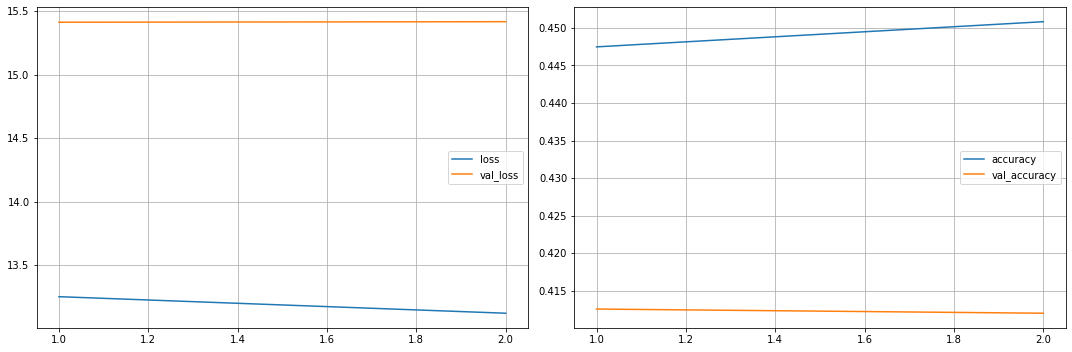

365/365 [==============================] - 2627s 7s/step - loss: 13.1223 - accuracy: 0.4508 - val_loss: 15.4158 - val_accuracy: 0.4120
Epoch 3/30
208/365 [================>.............] - ETA: 16:53 - loss: 14.0168 - accuracy: 0.4278

In [ ]:
image_caption_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping, cp_callback, PlotLearning()]
)

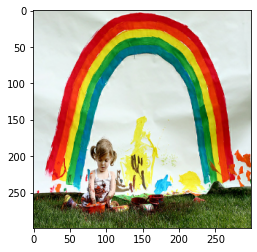

'<start>  a little girl is sitting in the grass'

In [ ]:
image_caption_model.predict('/content/flickr30k_images/flickr30k_images/1002674143.jpg')

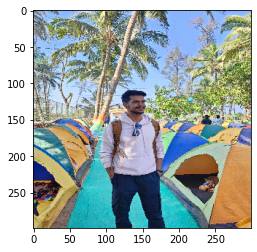

'<start>  a man in a white shirt and blue jeans is standing in front of a tent'

In [ ]:
image_caption_model.predict('3.jpg')

In [ ]:
from tqdm import tqdm

predictions = []
for image in tqdm(X_validation[:1000]):
  predictions.append(image_caption_model.predict(image))

predictions

In [ ]:
# pd.Series(predictions).to_csv('/content/drive/MyDrive/Quick Data/Image Caption Generator/val_prediction_1000.csv')


In [ ]:
predictions = pd.read_csv('/content/drive/MyDrive/Quick Data/Image Caption Generator/val_prediction_1000.csv')
predictions.drop(predictions.columns[[0]], axis=1, inplace=True)
predictions.head()

,0
0,<start> a man in a blue shirt and red pants i...
1,<start> a woman in a black dress is playing a...
2,<start> a woman in a red shirt and black pant...
3,<start> a baseball player is throwing a ball
4,<start> a snowboarder is standing in front of...


In [ ]:
predictions_words = [sentence[0].split(' ') for sentence in predictions.values]
predictions_words_new = []
for sentence_words in predictions_words:
  sentence_words.remove('')
  sentence_words.append('<end>')
  predictions_words_new.append(sentence_words)
predictions_words_new[1]

['<start>',
 'a',
 'woman',
 'in',
 'a',
 'black',
 'dress',
 'is',
 'playing',
 'a',
 'violin',
 '<end>']

In [ ]:
y_validation[1]

['<start> A musician with short blondhair and wearing a blue scarf and vest plays a string instrument while singing <end>',
 '<start> A woman is playing the violin and singing at the same time while sitting in a chair <end>',
 '<start> A woman with closed eyes is playing a cello and singing into a microphone <end>',
 '<start> A woman closes her eyes as she plays her cello <end>',
 '<start> Lady sings and plays the cello with emotion <end>']

In [ ]:
y_validation_words = [[sentence.lower().split(' ') for sentence in references] for references in y_validation[:1000]]


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

corpus_bleu(y_validation_words,predictions_words_new,weights=[1,0,0,0])

0.6883452362862786